In [11]:
%matplotlib inline 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, sys

root = os.getcwd()

Compare the features from the metadata given by the study authors with that obtained from raw2feat and using IPO

Questions:
1. are features reproducable?
2. what are the counts of features and how do they compare with different processing?
3. what are the features?

Extra (prob not from 1 study):
1. what do the feature counts mean in the metadata? are they intensities? normalized somehow? 
2. How do we map these to KEGG or METLIN (MS/MS, so prob not this)


In [12]:
def drop_redundant(df):
    seen = [] 
    indexes = []
    for ind, row in df.iterrows():
        if (row['mass_to_charge'], row['charge'], row['retention_time']) not in seen:
            seen.append((row['mass_to_charge'], row['charge'], row['retention_time']))
            continue
        else:
            indexes.append(ind)        
    return df.drop(indexes)

In [3]:
# load all the data
study = '/MTBLS315/'
study_category = 'Malaria'
# data from the authors
author_s = 's_NMFI and BSI diagnosis.txt'
a_s = pd.read_csv(root+study+author_s, sep='\t')
# a_s has source name, sample name (name used to id, map *MS to this), factor value (class label), severe mal nut
# prior malaria treatment, and prior antibiotic treatment

author_a = 'a_UPLC_NEG_nmfi_and_bsi_diagnosis.txt'
a_a = pd.read_csv(root+study+author_a, sep='\t')
# a_a has sample name, extract name (=sample name), MS assay name (name of actual *MS file without extension), 
# raw spectral data file (name with extension)
# all data:
# ['Sample Name', 'Protocol REF', 'Parameter Value[Post Extraction]', 'Parameter Value[Derivatization]', 
# 'Extract Name', 'Protocol REF.1', 'Parameter Value[Chromatography Instrument]', 'Term Source REF', 
# 'Term Accession Number', 'Parameter Value[Column model]', 'Parameter Value[Column type]', 'Labeled Extract Name',
# 'Label', 'Term Source REF.1', 'Term Accession Number.1', 'Protocol REF.2', 'Parameter Value[Scan polarity]', 
# 'Parameter Value[Scan m/z range]', 'Parameter Value[Instrument]', 'Term Source REF.2', 'Term Accession Number.2', 
# 'Parameter Value[Ion source]', 'Term Source REF.3', 'Term Accession Number.3', 'Parameter Value[Mass analyzer]', 
# 'Term Source REF.4', 'Term Accession Number.4', 'MS Assay Name', 'Raw Spectral Data File', 'Protocol REF.3',
# 'Normalization Name', 'Derived Spectral Data File', 'Protocol REF.4', 'Data Transformation Name', 
# 'Metabolite Assignment File']

author_m = 'm_UPLC_NEG_nmfi_and_bsi_diagnosis_v2_maf.tsv'
a_m = pd.read_csv(root+study+author_m, sep='\t')
# a_m is the metabolite assignment file: 
#['database_identifier', 'chemical_formula', 'smiles', 'inchi', 'metabolite_identification', 
# 'mass_to_charge', 'fragmentation', 'modifications', 'charge', 'retention_time', 'taxid', 
# 'species', 'database', 'database_version', 'reliability', 'uri', 'search_engine', 'search_engine_score',
# 'smallmolecule_abundance_sub', 'smallmolecule_abundance_stdev_sub', 'smallmolecule_abundance_std_error_sub', 
#'1014_N', '1035_N', '1016_N', '1037_N', '1058_N', '1018_N', '1039_N', '1052_N', '1050_N', '1010_N', '1031_N', 
# '1056_N', '1012_N', '1033_N', '1054_N', '1002_N', '1048_N', '1004_N', '1027_N', '1046_N', '1006_N', '1029_N',
# '1040_N', '1061_N', '1021_N', '1044_N', '1067_N', '1023_N', '1042_N', '1065_N', '1013_N', '1036_N', '1059_N',
# '1038_N', '1057_N', '1017_N', '1019_N', '1051_N', '1030_N', '1032_N', '1055_N', '1011_N', '1034_N', '1053_N', 
# '1003_N', '1024_N', '1049_N', '1005_N', '1026_N', '1068_N', '1007_N', '1009_N', '1041_N', '1062_N', '1060_N', 
# '1020_N', '1045_N', '1066_N', '1001_N', '1043_N', '1064_N']
print('With redundant information: ', a_m.shape)
a_m_nonred = drop_redundant(a_m)
print('After dropping redundant info: ', a_m_nonred.shape)
features = a_m_nonred.iloc[:,21:]


/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


With redundant information:  (12385, 82)
After dropping redundant info:  (934, 82)


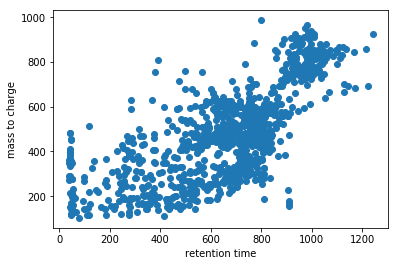

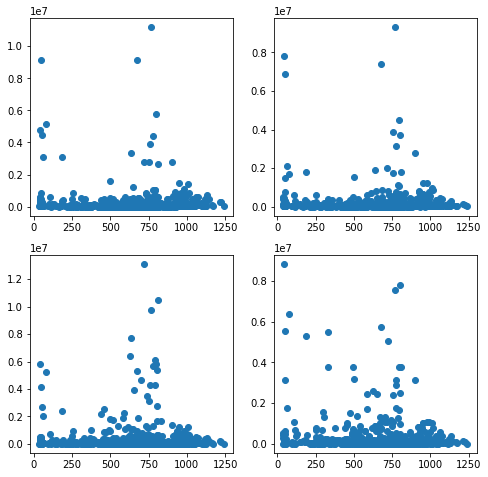

In [4]:
# Get an idea of what the feature-table data is from the authors:

plt.scatter(a_m_nonred['retention_time'], a_m_nonred['mass_to_charge'])
plt.xlabel('retention time')
plt.ylabel('mass to charge')
plt.show()

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.scatter(a_m_nonred['retention_time'], a_m_nonred['1014_N'])
plt.subplot(222)
plt.scatter(a_m_nonred['retention_time'], a_m_nonred['1016_N'])
plt.subplot(223)
plt.scatter(a_m_nonred['retention_time'], a_m_nonred['1035_N'])
plt.subplot(224)
plt.scatter(a_m_nonred['retention_time'], a_m_nonred['1001_N'])
plt.show()

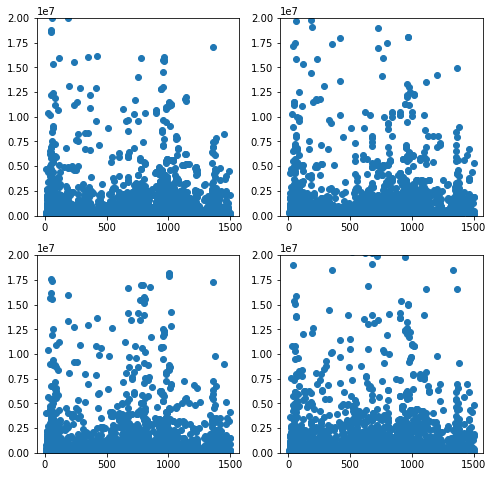

In [51]:
# data from my processing, using raw2feat.py (input was mzML data)
r2f_dir = 'mzML_N_full/'
path = root+study+r2f_dir
possible_labels = ['malaria', 'bacterial', 'non-malaria']
r2f_neg_uplc_data_align = ['MTBLS315_mzML_N.aligned_table.batch_malaria.negative.csv',\
'MTBLS315_mzML_N.aligned_table.batch_bacterial.negative.csv',\
'MTBLS315_mzML_N.aligned_table.batch_non-malarial.negative.csv']
r2f_neg_uplc_data_all = ['MTBLS315_mzML_N.all_peaks.batch_malaria.negative.csv',\
'MTBLS315_mzML_N.all_peaks.batch_bacterial.negative.csv',\
'MTBLS315_mzML_N.all_peaks.batch_non-malarial.negative.csv']

data = {}
for label, file in zip(possible_labels, r2f_neg_uplc_data_align):
    data[label] = pd.read_csv(path+file, sep=',')
malaria = data['malaria']
bacterial = data['bacterial']
non_mal = data['non-malaria']

# print(list(malaria))
# print(list(bacterial))
# print(list(non_mal))

#Get an idea of what the time vs mass-peak area is 
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.scatter(malaria['rt'], malaria['X1014_N'])
plt.ylim(0,2e7)
plt.subplot(222)
plt.scatter(malaria['rt'], malaria['X1016_N'])
plt.ylim(0,2e7)
plt.subplot(223)
plt.scatter(malaria['rt'], malaria['X1035_N'])
plt.ylim(0,2e7)
plt.subplot(224)
plt.scatter(malaria['rt'], malaria['X1001_N'])
plt.ylim(0,2e7)
plt.show()
    

In [138]:
r2f_1014 = malaria[['mz','X1014_N']]
r2f_1014 = r2f_1014[r2f_1014.X1014_N > 0].round(4)
print(r2f_1014.shape)

a_1014 = a_m_nonred[['mass_to_charge','1014_N']]
a_1014 = a_1014.dropna().round(4)
a_1014 = a_1014.sort_values(by=['1014_N'])
print(a_1014.head)

# Find the masses that are shared between the data sets. 
seen = []
shared = []
masses_a = sorted(a_1014['mass_to_charge'].values)
masses_r2f = r2f_1014['mz'].values
for ele in masses_a:
    if ele in masses_r2f:
        shared.append(ele)

print(len(shared))

(11416, 2)
<bound method NDFrame.head of        mass_to_charge        1014_N
734          507.3313  1.159366e+03
4608         295.1907  1.325092e+03
12004        473.2746  1.484090e+03
5270         525.4525  1.633736e+03
3175         446.2893  1.770323e+03
3406         329.2326  1.782254e+03
2447         147.0658  1.871673e+03
7312         429.1754  2.068612e+03
991          151.0396  2.084588e+03
10376        446.2911  2.106269e+03
2988         321.2063  2.142605e+03
3428         450.2994  2.185684e+03
4087         377.1958  2.233963e+03
9591         463.2882  2.317257e+03
3157         517.3132  2.360579e+03
7756         549.3049  2.567451e+03
1969         204.0659  2.585941e+03
1094         529.4257  2.597040e+03
10291        155.1073  2.717729e+03
6522         469.3159  2.809311e+03
11107        451.2691  2.816759e+03
11400        445.2431  2.837503e+03
6523         509.3842  2.903214e+03
4377         163.0396  3.110624e+03
5939         443.1731  3.114818e+03
6115         343.2483  

If I understand the output of the above cell correctly, when I look at the raw TIC for this mML file it appears they are just taking the highest intensity for a peak. NOT integrating, AND they ignored a big random peak that eluted at the start of the run with mass ~290 which is the insanely large value in the r2f dataframe (~1e9 when integrated which is what the XCMS process appears to be doing). 

I dont think we can really compare the features between the two datasets. 
plus the masses seem to be different in each dataset (unless rounded to 3/4 decimals)

CONCLUSION: you cannot compare the intensities from raw2feat with the data from the authors since they are different intensities. 

This leads to the question: Is it better to use the intensity of the mass-peak at its max or the integrated area?

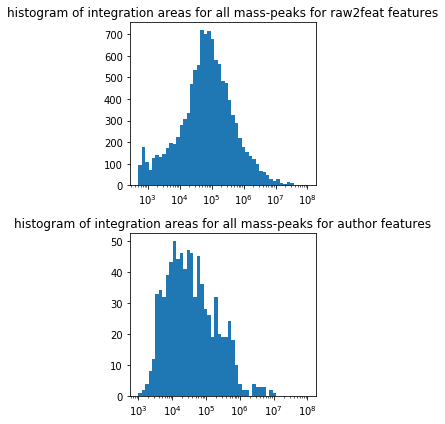

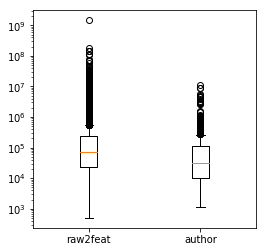

In [139]:
#sort just to make it easier to think about when printing, no other function
r2f_sorted = r2f_1014.sort_values(by='X1014_N')
#look at histogram of peak areas
plt.figure(figsize=(5,6))
plt.subplot(211)
plt.hist(r2f_sorted['X1014_N'].values, bins=np.logspace(np.log10(5e2),np.log10(1e8), 50))
plt.xscale('log')
plt.title('histogram of integration areas for all mass-peaks for raw2feat features')
plt.subplot(212)
plt.hist(a_1014['1014_N'].values, bins=np.logspace(np.log10(1e3),np.log10(1e8), 50))
plt.xscale('log')
plt.title('histogram of integration areas for all mass-peaks for author features')
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,4))
plt.boxplot([r2f_sorted['X1014_N'].values, a_1014['1014_N'].values], labels=['raw2feat', 'author'])
plt.yscale('log')
plt.show()

Might be interesting to look how you can do at classification using different fractions of this. 
    How important are the very low intensity 'features' (especially since the are probably noise, and it doesnt really make sense to have 12000+ features when the following is the TIC (here I'd say 200 features max makes sense):
    ![image.png](attachment:image.png)
  1. Here it looks like ~1-6e5 for a single time is the baseline intensity, would atleast cut off here 
  2. Maybe also trim the peaks that are integrated over some crazy time. >30s or 1m (?)
  3. Also (se below) it looks like there are a lot of 0 time width peaks...

number of time-width 0 peaks in the raw2feat data:  5118


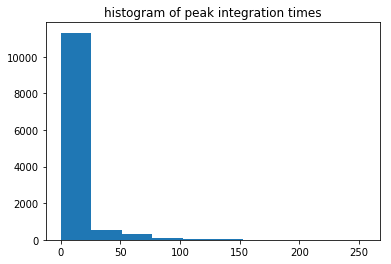

In [137]:
time_diff = malaria['rtmax'] - malaria['rtmin']
time_diff = time_diff.values
zeroes = time_diff[time_diff == 0]
print("number of time-width 0 peaks in the raw2feat data: ", len(zeroes))

plt.hist(time_diff, 10)
plt.title('histogram of peak integration times')
plt.show()
# here we can see the majority of peak integrations are very short with 5118 zero length peaks

Looking at the LC data to see if the authors used single peak intensity values or integrated intensities. 

In [13]:
# load all the data
study = '/MTBLS315/'
study_category = 'Malaria'
# data from the authors
author_s = 's_NMFI and BSI diagnosis.txt'
a_s = pd.read_csv(root+study+author_s, sep='\t')
# a_s has source name, sample name (name used to id, map *MS to this), factor value (class label), severe mal nut
# prior malaria treatment, and prior antibiotic treatment

author_a = 'a_LC_nmfi_and_bsi_diagnosis.txt'
a_a = pd.read_csv(root+study+author_a, sep='\t')
# a_a has sample name, extract name (=sample name), MS assay name (name of actual *MS file without extension), 
# raw spectral data file (name with extension)
# all data:
# ['Sample Name', 'Protocol REF', 'Parameter Value[Post Extraction]', 'Parameter Value[Derivatization]', 
# 'Extract Name', 'Protocol REF.1', 'Parameter Value[Chromatography Instrument]', 'Term Source REF', 
# 'Term Accession Number', 'Parameter Value[Column model]', 'Parameter Value[Column type]', 'Labeled Extract Name',
# 'Label', 'Term Source REF.1', 'Term Accession Number.1', 'Protocol REF.2', 'Parameter Value[Scan polarity]', 
# 'Parameter Value[Scan m/z range]', 'Parameter Value[Instrument]', 'Term Source REF.2', 'Term Accession Number.2', 
# 'Parameter Value[Ion source]', 'Term Source REF.3', 'Term Accession Number.3', 'Parameter Value[Mass analyzer]', 
# 'Term Source REF.4', 'Term Accession Number.4', 'MS Assay Name', 'Raw Spectral Data File', 'Protocol REF.3',
# 'Normalization Name', 'Derived Spectral Data File', 'Protocol REF.4', 'Data Transformation Name', 
# 'Metabolite Assignment File']

author_m = 'm_LC_nmfi_and_bsi_diagnosis_v2_maf.tsv'
a_m = pd.read_csv(root+study+author_m, sep='\t')
# a_m is the metabolite assignment file: 
#['database_identifier', 'chemical_formula', 'smiles', 'inchi', 'metabolite_identification', 
# 'mass_to_charge', 'fragmentation', 'modifications', 'charge', 'retention_time', 'taxid', 
# 'species', 'database', 'database_version', 'reliability', 'uri', 'search_engine', 'search_engine_score',
# 'smallmolecule_abundance_sub', 'smallmolecule_abundance_stdev_sub', 'smallmolecule_abundance_std_error_sub', 
# A BUNCH OF SAMPLES like: '47_P-57-MCMA565_522-16536']
print('With redundant information: ', a_m.shape)
a_m_nonred = drop_redundant(a_m)
print('After dropping redundant info: ', a_m_nonred.shape)
features = a_m_nonred.iloc[:,21:]

/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


With redundant information:  (8207, 82)
After dropping redundant info:  (554, 82)


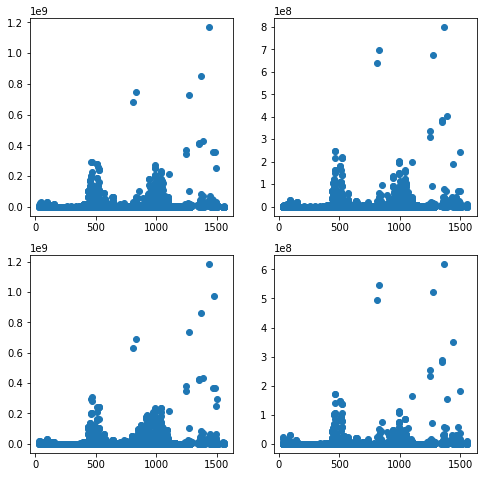

In [14]:
# data from my processing, using raw2feat.py (input was mzML data)
r2f_dir = 'mzXML_P_full/'
path = root+study+r2f_dir
possible_labels = ['malaria', 'bacterial', 'non-malaria']
r2f_data_align = ['MTBLS315_full_cdf_to_mzXML.aligned_table.batch_malaria.positive.csv',\
'MTBLS315_full_cdf_to_mzXML.aligned_table.batch_bacterial.positive.csv',\
'MTBLS315_full_cdf_to_mzXML.aligned_table.batch_non-malarial.positive.csv']
r2f_data_all = ['MTBLS315_full_cdf_to_mzXML.all_peaks.batch_malaria.positive.csv',\
'MTBLS315_full_cdf_to_mzXML.all_peaks.batch_bacterial.positive.csv',\
'MTBLS315_full_cdf_to_mzXML.all_peaks.batch_non-malarial.positive.csv']

data = {}
for label, file in zip(possible_labels, r2f_data_align):
    data[label] = pd.read_csv(path+file, sep=',')
malaria = data['malaria']
bacterial = data['bacterial']
non_mal = data['non-malaria']

# print(list(malaria))
# print(list(bacterial))
# print(list(non_mal))

#Get an idea of what the time vs mass-peak area is 
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.scatter(malaria['rt'], malaria['X15_P.2.MCMA430_522.16481'])
# plt.ylim(0,2e9)
plt.subplot(222)
plt.scatter(malaria['rt'], malaria['X35_P.3.MCMA431_522.16482'])
# plt.ylim(0,2e9)
plt.subplot(223)
plt.scatter(malaria['rt'], malaria['X13_P.37.MCMA497_522.16516'])
# plt.ylim(0,2e9)
plt.subplot(224)
plt.scatter(malaria['rt'], malaria['X93_P.60.MURB085_522.16539'])
# plt.ylim(0,2e9)
plt.show()

(13979, 2)
(12179, 2)


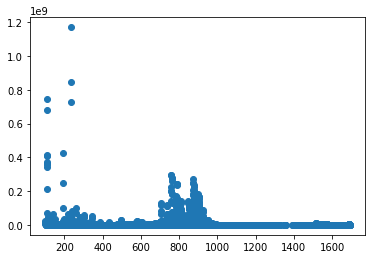

29


In [15]:
r2f_MCMA430 = malaria[['mz','X15_P.2.MCMA430_522.16481']]
r2f_MCMA430 = r2f_MCMA430.rename(index=str, columns={"X15_P.2.MCMA430_522.16481": "intensities"})
print(r2f_MCMA430.shape)
r2f_MCMA430 = r2f_MCMA430[r2f_MCMA430.intensities > 0].round(4)
print(r2f_MCMA430.shape)

plt.scatter(r2f_MCMA430['mz'], r2f_MCMA430['intensities'])
plt.show()

a_MCMA430 = a_m_nonred[['mass_to_charge','15_P-2-MCMA430_522-16481']]
a_MCMA430 = a_MCMA430.dropna().round(4)
a_MCMA430 = a_MCMA430.sort_values(by=['15_P-2-MCMA430_522-16481'])
# print(a_MCMA430.head)

# Find the masses that are shared between the data sets. 
seen = []
shared = []
masses_a = sorted(a_MCMA430['mass_to_charge'].values)
masses_r2f = r2f_MCMA430['mz'].values
for ele in masses_a:
    if ele in masses_r2f:
        shared.append(ele)

print(len(shared))

raw 2 feat:  <bound method NDFrame.head of               mz   intensities
1145    414.9657  1.414534e+03
57      121.0831  1.533776e+03
5202    786.9753  1.842235e+03
169     180.9667  1.891777e+03
787     339.0629  2.031024e+03
143     167.0285  2.128658e+03
3478    721.0291  2.193314e+03
81      137.0479  2.341524e+03
990     371.0072  2.417102e+03
12629  1066.9210  2.457522e+03
12444  1018.9706  2.522345e+03
9388    896.8096  2.581762e+03
9389    896.8106  2.583829e+03
9387    896.8077  2.585010e+03
1512    521.4174  2.596080e+03
12380  1010.9066  2.599742e+03
12013   985.8479  2.615655e+03
12014   985.8507  2.615655e+03
13066  1301.9682  2.615855e+03
12974  1222.7099  2.617853e+03
12973  1222.7065  2.618182e+03
12476  1023.9288  2.656650e+03
1785    565.4029  2.724392e+03
9151    890.8474  2.778230e+03
3950    743.0083  2.802211e+03
12631  1067.9283  2.812359e+03
12630  1067.9253  2.813283e+03
1003    372.0621  2.852584e+03
13134  1356.3715  2.905767e+03
13133  1356.3663  2.907390e

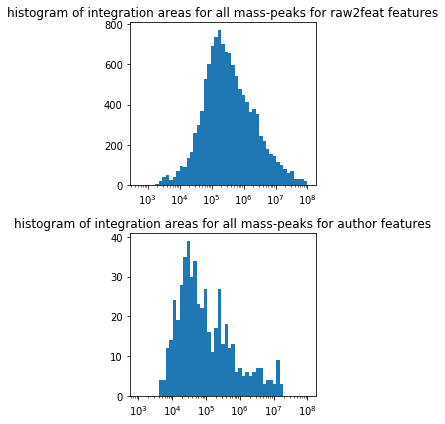

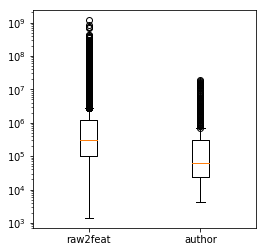

In [23]:
#sort just to make it easier to think about when printing, no other function
r2f_sorted = r2f_MCMA430.sort_values(by='intensities')
print('raw 2 feat: ',r2f_sorted.head)
print('author peaks: ', a_MCMA430[['15_P-2-MCMA430_522-16481','mass_to_charge']].head)
#look at histogram of peak areas
plt.figure(figsize=(5,6))
plt.subplot(211)
plt.hist(r2f_sorted['intensities'].values, bins=np.logspace(np.log10(5e2),np.log10(1e8), 50))
plt.xscale('log')
plt.title('histogram of integration areas for all mass-peaks for raw2feat features')
plt.subplot(212)
plt.hist(a_MCMA430['15_P-2-MCMA430_522-16481'].values, bins=np.logspace(np.log10(1e3),np.log10(1e8), 50))
plt.xscale('log')
plt.title('histogram of integration areas for all mass-peaks for author features')
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,4))
plt.boxplot([r2f_sorted['intensities'].values, a_MCMA430['15_P-2-MCMA430_522-16481'].values], labels=['raw2feat', 'author'])
plt.yscale('log')
plt.show()

LCMS-TIC: 
![image.png](attachment:image.png)

Looks like the authors again just use the peak intensities....Also we should have a max integration time cut off...

![image.png](attachment:image.png)